# FINAL PROJECT: BUILDING AND TESTING QUANTITATIVE EQUITY TRADING STRATEGIES

## 1.Get the data

First, we import the necessary libraries for the entire task


In [ ]:
import pandas as pd
from pypfopt.risk_models import CovarianceShrinkage
import numpy as np
from pypfopt.efficient_frontier import EfficientFrontier
import pyfolio as pf

We then extract the files and perform some minor adjustments for an easier handling of their content

In [2]:
#We extract the file using pandas
returns = pd.read_excel(r"Where you left the file\UK_Returns.xlsx")
mkt_cap = pd.read_excel(r"Where you left the file\UK_MarketValues.xlsx")

#We rename the TimePeriod column as such
returns = returns.rename(columns = {"Unnamed: 0": "TimePeriod"})
mkt_cap = mkt_cap.rename(columns = {"Unnamed: 0": "TimePeriod"})

#We drop the last rows for each dataframe as it is the 1st of a month and will not be useful going forward
mkt_cap = mkt_cap.drop([len(mkt_cap)-1])
returns = returns.drop([len(returns)-1])

#we set the timestamp as index
mkt_cap = mkt_cap.set_index("TimePeriod")
returns = returns.set_index("TimePeriod")


## 2. Data Modelling

return_month_trading_days will add an extra column to the input in which will be detailed the total amount of trading days for each month. Going forward, this will allow us to compute strictly correct mean returns. Also, we will be able to handle in an easier fashion weights estimation for the following month.

In [3]:
def return_month_trading_days(x):
    trading_days = np.zeros(len(x))
    month_temp = 6 #instantiating month at first month present in db for looping purpose
    temp = 0 #will be use jointly with idx to fill the trading days array quicker
    counter_month_day = 1
    for idx, values in enumerate(x.index):
        if values.month != month_temp:
            trading_days[temp:idx] = counter_month_day
            month_temp = values.month
            counter_month_day = 1
            temp = idx
        elif values.month == month_temp:
            counter_month_day +=1
            if ((values.year == 2017) and (values.day == 31) and (values.month == 10)):
                trading_days[temp:idx+1] = counter_month_day
    x["BusinessDays"] = trading_days
    return x

So as to have a fairer comparison between each strategy, we will use the same method in their building process. Hence, the function below creates a market cap weight for the following month by looking at the average weight per asset during the past 12 months. Using daily weights would have made our comparison less relevant, mainly due to the fact that rebalancing such portfolio on a daily basis would generate trading costs greatly surpassing the potential returns of the strategy. Nonetheless, by using such approach we deviated from what would be a theoretical market weighted portfolio. We choose to do so as the class focused on practical applications.

In [4]:
def mkt_cap_weights(mkt_cap):
    month_temp = 1 #instantiating month at first month present in db for looping purposes
    mkt_cap = return_month_trading_days(mkt_cap)
    mkt_cap_weights = mkt_cap.div(mkt_cap.sum(axis=1), axis=0)
    month_counter = 0
    act_values = 0
    idx_dumb = 0
    month_day_sum = [] #will provide count of business day for the past year
    mkt_weights_df = pd.DataFrame(columns = mkt_cap.columns)
    for idx, values in enumerate(mkt_cap.index):
        if values.month != month_temp:
            month_temp = values.month
            if month_counter < 11:
                month_counter +=1
                month_day_sum.append(int(mkt_cap.BusinessDays.iloc[idx-1]))
            else:
                act_values +=1
                if act_values ==1:
                    idx_dumb = idx
                month_day_sum.pop(0) #erase 1st (oldest) month in array since we want the sum of only the past 12 monthes business days
                month_day_sum.append(int(mkt_cap.BusinessDays.iloc[idx-1]))
                past_year_business_day = sum(month_day_sum)
                #instantiating dict of weights of same length that original panda dataframe
                for i in range(int(mkt_cap["BusinessDays"].iloc[idx])):
                    mkt_weights_df = mkt_weights_df.append(pd.Series(mkt_cap_weights[(idx-past_year_business_day):idx].mean(axis = 0), index=mkt_weights_df.columns), ignore_index = True)
    mkt_weights_df = mkt_weights_df.drop(["BusinessDays"], axis = 1)
    mkt_weights_df["TimePeriod"] = mkt_cap.index[idx_dumb:]
    mkt_weights_df = mkt_weights_df.set_index("TimePeriod")
    return mkt_weights_df

The following function uses the Ledoit & Wolf method to estimate the covariance matrix robustly. We used the past 12 months returns as previously mentioned. We will also try the following three priors to the Ledoit & Wolf Method:
-	Constant variance where the target is the diagonal matrix comprised of the mean of asset variances on the diagonal and zeroes elsewhere. See Ledoit and Wolf 2004.
-	Sharpe’s single index model in which we use as market returns simply the daily average return of the entire universe at hand (which appears to be FTSE100). See Ledoit and Wolf 2001;
-	Average correlation model. See Ledoit and Wolf 2003.

Once we have the shrunk covariance matrix, we use it together with the mean returns to generate the Global Minimum Variance Portfolio (GMVP). Finally, we "clean" the weights as the vast majority of the portfolio will be comprised of infinitesimally small allocations. Since it is impossible to build such positions, we proportionally reallocate the weights of assets for which the allocation is inferior to 0.0001. It is also important to note that this is a long only portfolio given the used benchmark.

In [5]:
### Create weights to construct minimum variance portfolio using different technique to shrink the covariance matrix
def building_portfolio(returns, cov_shrinkage_type):
    month_temp = 1 #instantiating month at first month present in db for looping purposes
    #we add a day column so as to estimate mean returns adequately when finding the portfolio that minimizes variance
    returns = return_month_trading_days(returns)
    month_counter = 0
    month_day_sum = [] #will provide count of business day for the past year
    weights_timestamp = dict()
    for idx, values in enumerate(returns.index):
        if values.month != month_temp:
            month_temp = values.month
            if month_counter < 11:
                month_counter +=1
                month_day_sum.append(int(returns.BusinessDays.iloc[idx-1]))
            else:
                month_day_sum.pop(0) #erase 1st (oldest) month in array since we want the sum of only the past 12 monthes business days
                month_day_sum.append(int(returns.BusinessDays.iloc[idx-1]))
                past_year_business_day = sum(month_day_sum)
                temp_mean_returns = returns.iloc[(idx-past_year_business_day):idx,0:-1].mean(axis=0)
                temp = returns.reset_index(drop=True)
                S = CovarianceShrinkage(temp.iloc[(idx-past_year_business_day):idx,0:-1], returns_data = True).ledoit_wolf(shrinkage_target = cov_shrinkage_type) #taking out timestamps and BusinessDays columns
                ef = EfficientFrontier(temp_mean_returns, S)#no short
                weights_unclean = ef.min_volatility() 
                weights = ef.clean_weights(cutoff = 0.0001)#we "clean" the weights as the vast majority of the portfolio will be comprised of infinitesimally small as it is impossible to build such a position; basically all negatives weights get set to 0
                #instantiating dict of weights of same length that original panda dataframe
                for i in range(int(returns["BusinessDays"].iloc[idx])):
                    weights_timestamp[returns.index[idx+i]] = weights
    return weights_timestamp

As best practice, we save the weights for two reasons:
-	Debugging activities are made easier since the data can be observed using excel
-	We bypass the repeated use of a computationally expensive process


In [6]:
#We Save the weights so as not to repeat this computationally expensive process
shrinkage_types = ["constant_variance", "single_factor", "constant_correlation"]
for elements in shrinkage_types:
    weights = building_portfolio(returns, elements)
    temp = pd.DataFrame.from_dict(weights, orient = "index")
    temp.to_csv(elements+".csv")

In [7]:
#Save the weights of market cap weighted portfolio
mkt_cap_weights(mkt_cap).to_csv("mktcapweights.csv")

Hence, we then extract the files again and perform the same minors adjustments as we did above

In [8]:
d = {}
portfolio_types = ["constant_variance", "single_factor", "constant_correlation", "mktcapweights"]
for element in portfolio_types:
    #Getting the csv of weights and transformating it into a csv
    d[element] = pd.read_csv(r'Where you left the file\'+element+'.csv')
    #Renaming TimePeriod Columns
    d[element] = d[element].rename(columns = {"Unnamed: 0": "TimePeriod"})
    #Setting TimePeriod as Index
    d[element] = d[element].set_index("TimePeriod")

Finally, we compute the following returns (for each weight methodology) in the mentioned order:
-	Weighted returns of the entire investment universe;
-	Total portfolio returns;
-	Cumulative returns:
    -	For each asset;
    -	For the portfolio.


In [9]:
data = returns.loc["1993-01-01":] #so as to be of same length than weights dataframe
returns_dic = {}
for element in d:
    #compute weighted returns
    returns_dic[element] = d[element]*data


In [10]:
#Compute portfolio returns
for element in returns_dic:
    total_ret = np.zeros(len(returns_dic[element]))
    for idx in range(len(returns_dic[element])):
        total_ret[idx] = returns_dic[element].iloc[idx].sum()
    returns_dic[element]["Total_ret"] = total_ret

In [11]:
#Cumulative returns
cum_returns = pd.DataFrame(index = data.index)
daily_returns = pd.DataFrame(index = data.index)
for element in returns_dic:
    cum_returns[element] = (returns_dic[element]["Total_ret"]+1).cumprod()
    daily_returns[element] = (returns_dic[element]["Total_ret"])

## 3. Results Interpretations

First, we plot the cumulative returns for all weighting strategy. We will focus on the covariance shrinking method providing the best returns and the market cap weighted portfolio.

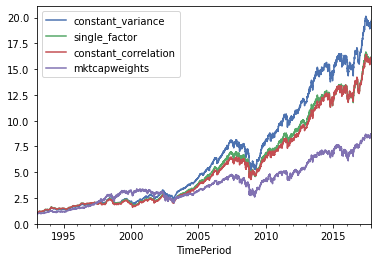

In [12]:
#Plot cumulative returns
cum_returns.plot()


As seen in class while studying the scientific paper written by Disatnik and Benninga (2007), single_factor and constant_correlation have more or less the same performance (and most importantly in relation to the scientific paper, out of sample standard deviation is almost equal as can be seen in the reports listed below). Also, the market cap weighted portfolio is overperformed by the GMVP constructed with all the covariance shrinking methods. Nonetheless, the constant-variance approach significantly outperforms other shrinking technics. Hence, to properly understand the mathematics behind this theorem, the following website comes in handy : https://www.arpm.co/lab/shrinkage-blending-assessing.html.
As can be seen below, the GMVP constructed with the constant variance shrinking approach (we will now call this portfolio the constant variance portfolio) returned 12.3% annual returns vs 8.8% for the market weighted portfolio. Over the entire sample, the respective cumulated returns grow to 1875.7% and 765.0%. Hence, the difference becomes quite substantial once compounding effect kicks in. Moreover, the standard deviation of the constant variance portfolio is 10.2%, or almost half of the 17.7% standard deviation for the market weighted portfolio. Obviously, these differences are translated into the Sharpe ratio which is equal to 1.19 for the constant variance portfolio and 0.56 for the market weighted allocation. The maximum drawdowns are quite similar, with 38.5% for the constant variance portfolio and 45.6% for the market weighted portfolio. The skewness of both approaches does show some degrees of difference. Whereas the market weighted portfolio exhibits some sort of symmetrical distribution of returns with a skew of 0.02, the constant variance returns distribution is moderately negatively skewed with a value of -0.59. This simply means that the tail on the left side of the distribution are longer/fatter than the tail on the right side. Following the lower volatility of this portfolio together with the lack of use of hedging technics for negative events, this does indeed make sense. Ultimatly, both strategies exhibit longer distribution and fatter tails with Kurtosis substantially above 3. Finally, many more descriptive outputs are available than the one that were discussed in class and can be seen by scrawling through the next cells results. We also included a direct comparisons of the constant variance portfolio and its benchmark, the market weighted portfolio.

To conclude, we showed which Ledoit & Wolf method provided the best out of sample risk reward ratio. A next step of interest would be to try to apply the same analysis on other samples. That would allow to see if the same conclusion is reached, and ultimately if the constant variance approach does allow for better covariance estimation during practical applications. Finally, we showed that for all covariance shrinking technics, the results are better in every aspect than for a market weighted approach.


Start date,1993-01-01
End date,2017-10-31
Total months,308
,Backtest
Annual return,12.3%
Cumulative returns,1875.7%
Annual volatility,10.2%
Sharpe ratio,1.19
Calmar ratio,0.32
Stability,0.98
Max drawdown,-38.5%


C:\Users\santi\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return getattr(obj, method)(*args, **kwds)


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,38.51,2007-10-31,2008-11-21,2009-12-29,565
1,26.20,2002-05-08,2003-02-13,2003-08-21,337
2,26.01,1998-06-08,2000-02-15,2000-12-27,668
3,18.80,2001-06-08,2001-09-21,2002-02-27,189
4,16.48,1994-02-03,1995-03-13,1995-08-18,402


C:\Users\santi\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\santi\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\santi\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
C:\Users\santi\Anaconda3\lib\site-packages\pandas\plotting\_matpl

C:\Users\santi\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\santi\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\santi\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
C:\Users\santi\Anaconda3\lib\site-packages\pandas\plotting\_matpl

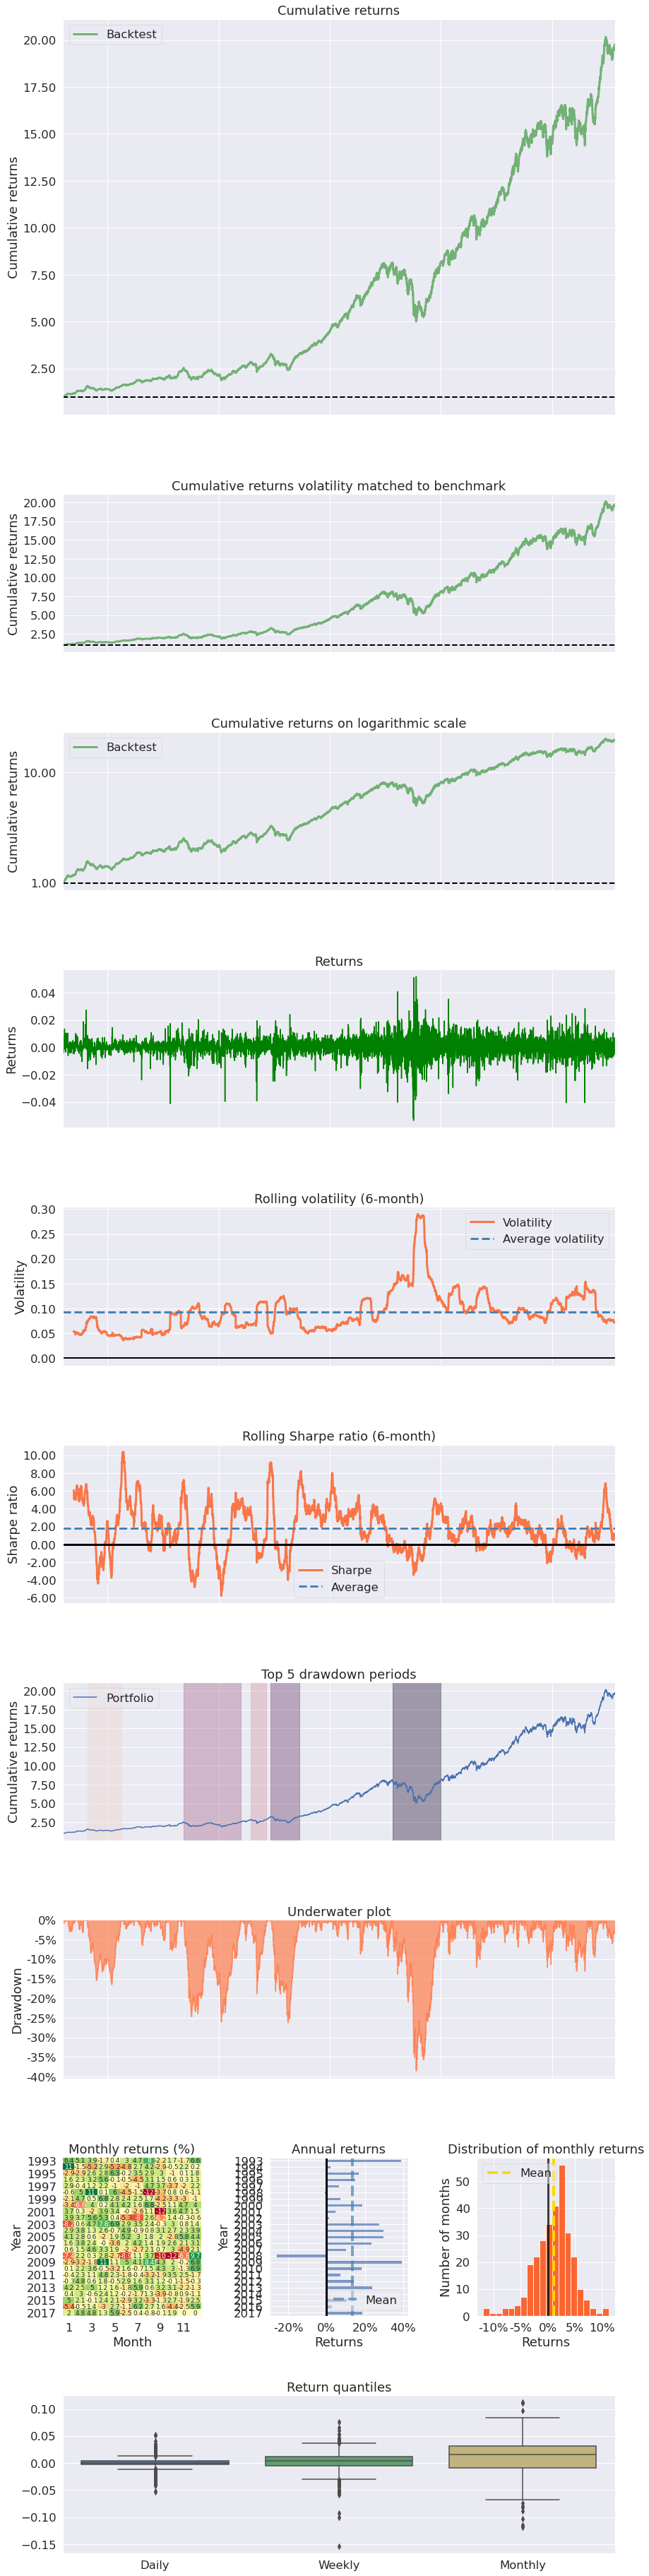

In [91]:
pf.create_returns_tear_sheet(daily_returns["constant_variance"])  

Start date,1993-01-01
End date,2017-10-31
Total months,308
,Backtest
Annual return,8.8%
Cumulative returns,765.0%
Annual volatility,17.7%
Sharpe ratio,0.56
Calmar ratio,0.19
Stability,0.90
Max drawdown,-45.6%


C:\Users\santi\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return getattr(obj, method)(*args, **kwds)


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,45.57,2007-06-15,2009-03-06,2010-04-15,740
1,40.36,2000-09-01,2003-03-12,2005-03-04,1176
2,23.62,1998-07-20,1998-10-05,1999-02-16,152
3,20.41,2015-04-15,2016-02-11,2016-09-02,363
4,19.08,2010-04-20,2010-07-01,2010-11-04,143


C:\Users\santi\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\santi\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\santi\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
C:\Users\santi\Anaconda3\lib\site-packages\pandas\plotting\_matpl

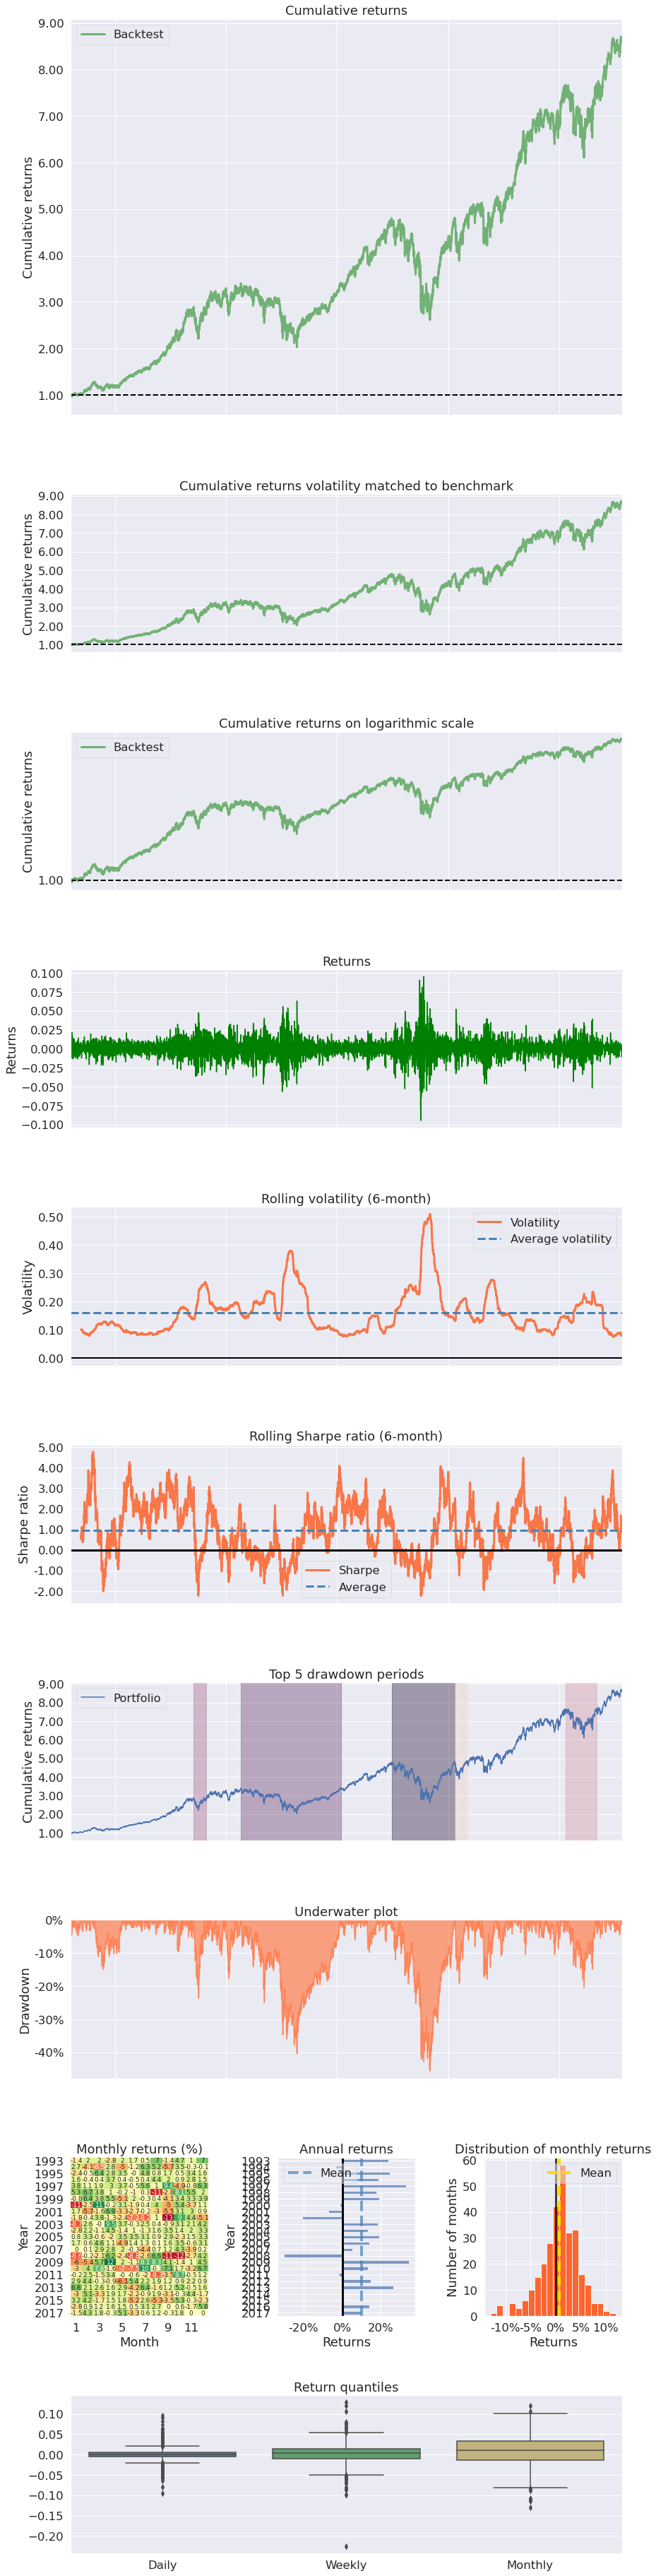

In [95]:
pf.create_returns_tear_sheet(daily_returns["mktcapweights"])

Start date,1993-01-01
End date,2017-10-31
Total months,308
,Backtest
Annual return,11.5%
Cumulative returns,1530.0%
Annual volatility,10.2%
Sharpe ratio,1.11
Calmar ratio,0.30
Stability,0.97
Max drawdown,-37.6%


C:\Users\santi\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return getattr(obj, method)(*args, **kwds)


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,37.63,2007-10-17,2008-11-21,2010-02-19,613
1,32.00,1998-06-08,2000-02-16,2001-06-01,780
2,28.22,2002-05-08,2003-02-13,2003-09-08,349
3,18.94,2001-06-08,2001-09-21,2002-03-06,194
4,14.86,1994-02-04,1995-03-13,1995-07-28,386


C:\Users\santi\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\santi\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\santi\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
C:\Users\santi\Anaconda3\lib\site-packages\pandas\plotting\_matpl

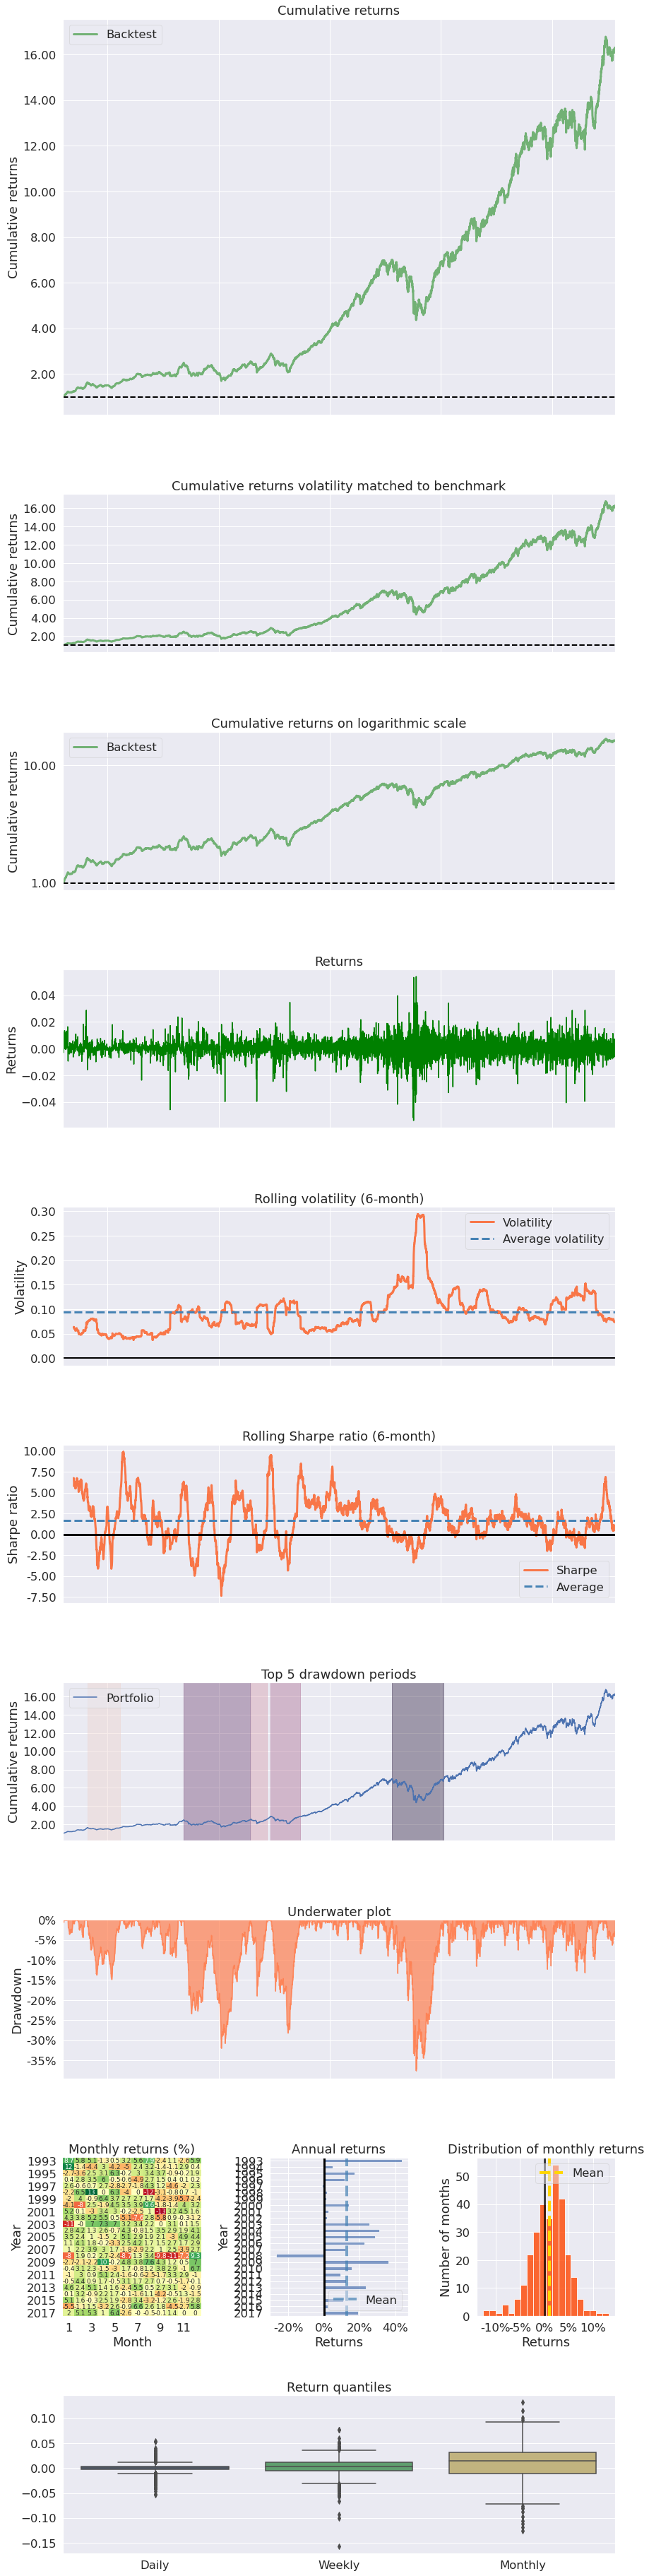

In [100]:
pf.create_returns_tear_sheet(daily_returns["single_factor"])

Start date,1993-01-01
End date,2017-10-31
Total months,308
,Backtest
Annual return,11.5%
Cumulative returns,1525.8%
Annual volatility,10.4%
Sharpe ratio,1.10
Calmar ratio,0.33
Stability,0.97
Max drawdown,-34.2%


C:\Users\santi\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return getattr(obj, method)(*args, **kwds)


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,34.23,1998-06-08,2000-02-16,2001-06-04,781
1,33.55,2007-10-31,2008-11-21,2009-12-22,560
2,27.43,2002-05-08,2003-02-14,2003-09-03,346
3,18.72,2001-06-08,2001-09-21,2002-03-11,197
4,13.76,1994-02-04,1995-03-13,1995-07-24,382


C:\Users\santi\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\santi\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\santi\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
C:\Users\santi\Anaconda3\lib\site-packages\pandas\plotting\_matpl

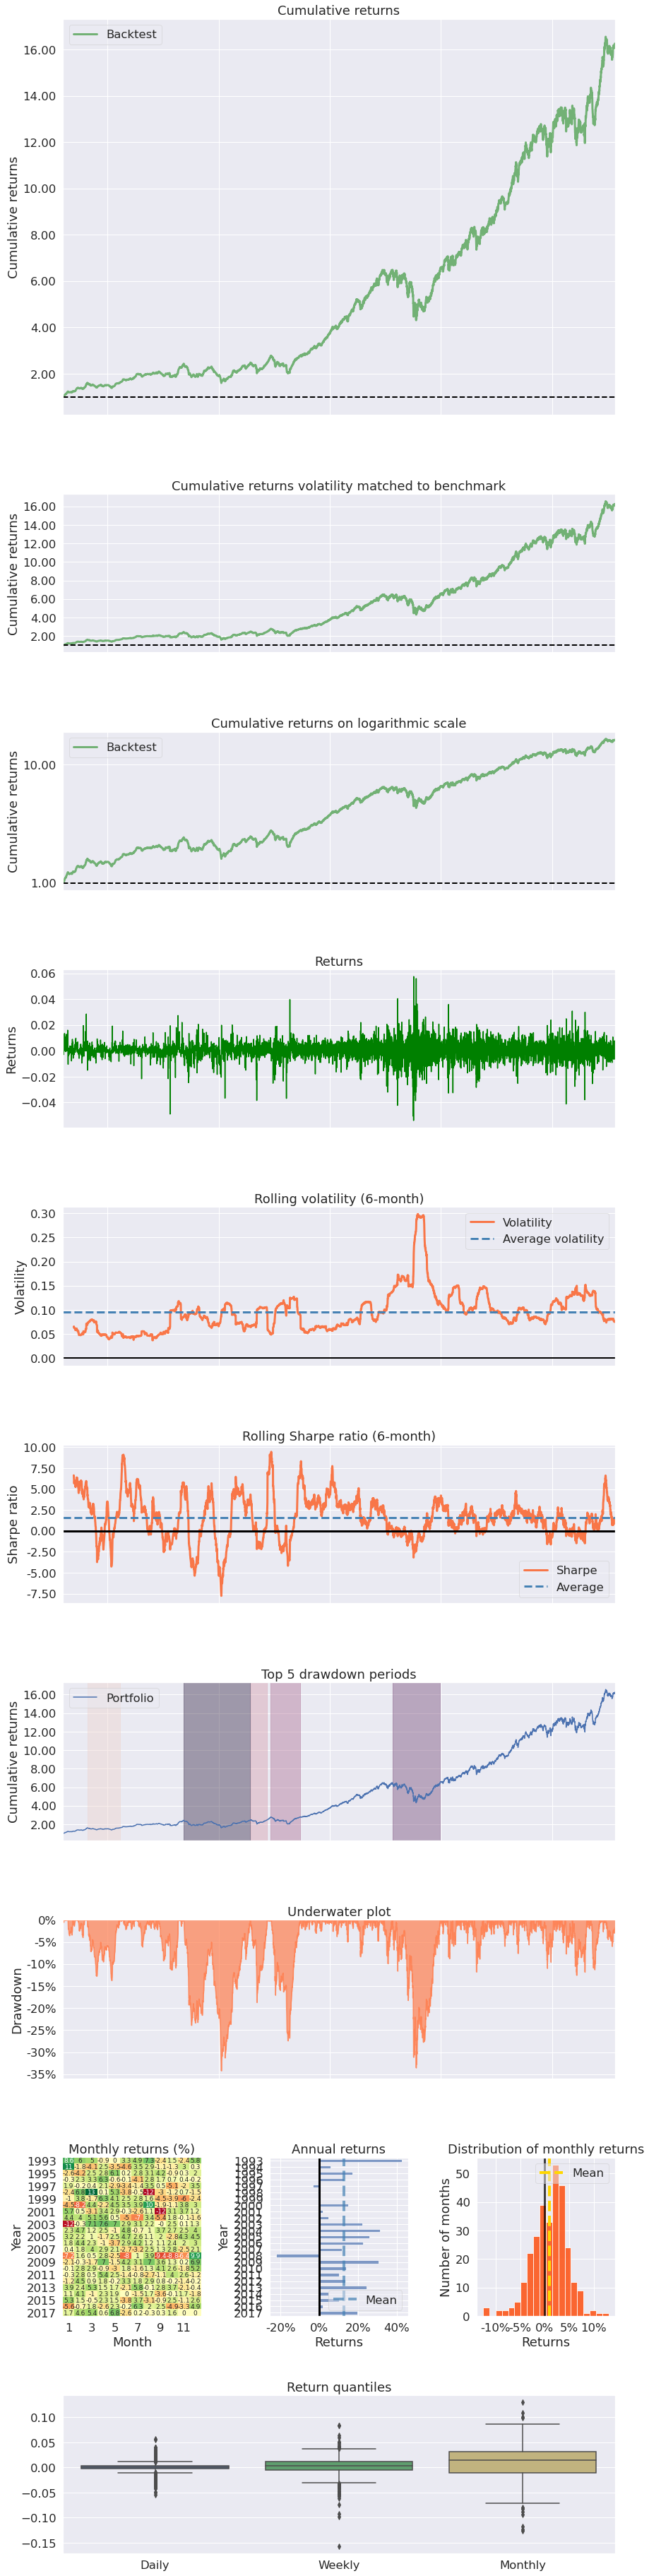

In [101]:
pf.create_returns_tear_sheet(daily_returns["constant_correlation"])

Start date,1993-01-01
End date,2017-10-31
Total months,308
,Backtest
Annual return,12.3%
Cumulative returns,1871.8%
Annual volatility,10.2%
Sharpe ratio,1.19
Calmar ratio,0.32
Stability,0.98
Max drawdown,-38.4%


C:\Users\santi\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return getattr(obj, method)(*args, **kwds)


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,38.45,2007-10-31,2008-11-21,2009-12-29,565
1,26.19,2002-05-08,2003-02-13,2003-08-21,337
2,26.04,1998-06-08,2000-02-15,2000-12-27,668
3,18.82,2001-06-08,2001-09-21,2002-02-27,189
4,16.46,1994-02-03,1995-03-13,1995-08-18,402


C:\Users\santi\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\santi\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\santi\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
C:\Users\santi\Anaconda3\lib\site-packages\pandas\plotting\_matpl

C:\Users\santi\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\santi\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\santi\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
C:\Users\santi\Anaconda3\lib\site-packages\pandas\plotting\_matpl

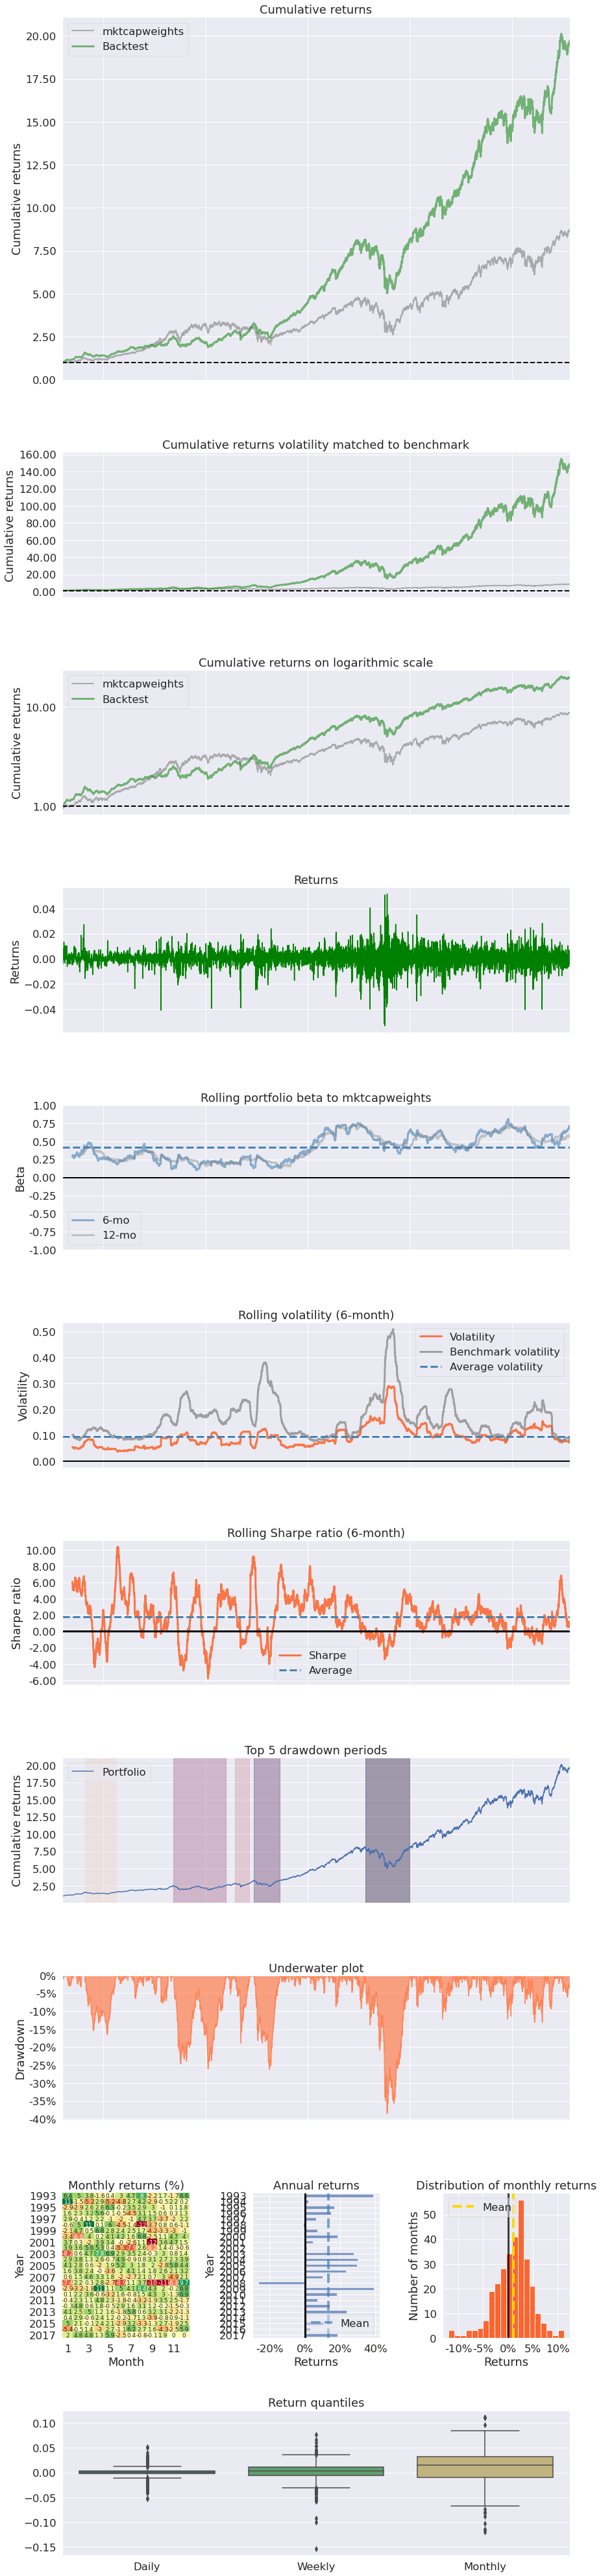

In [13]:
pf.create_returns_tear_sheet(daily_returns["constant_variance"], benchmark_rets = daily_returns["mktcapweights"])  